# Grad-CAM Explainability for Satellite Imagery-Based Property Valuation

This notebook provides visual explanations for the multimodal property valuation model
by highlighting regions of satellite imagery that influence predictions.

We use **Grad-CAM (Gradient-weighted Class Activation Mapping)** to:
- Identify environmentally relevant visual cues (green cover, roads, water)
- Validate that the CNN focuses on meaningful spatial patterns
- Support interpretability and trust in the multimodal framework


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
PROJECT_ROOT = "/content/drive/MyDrive/property_valuation_project"

In [4]:
IMAGE_DIR = f"{PROJECT_ROOT}/data/images_v2"
GRADCAM_DIR = f"{PROJECT_ROOT}/outputs/gradcam_v2"

In [5]:
import os
os.makedirs(GRADCAM_DIR, exist_ok=True)

In [6]:
print("Image directory:", IMAGE_DIR)
print("Grad-CAM output directory:", GRADCAM_DIR)

Image directory: /content/drive/MyDrive/property_valuation_project/data/images_v2
Grad-CAM output directory: /content/drive/MyDrive/property_valuation_project/outputs/gradcam_v2


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

cnn_backbone = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    pooling=None
)

cnn_backbone.trainable = False
cnn_backbone.summary()



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
for layer in cnn_backbone.layers[-20:]:
    print(layer.name, type(layer))

block6d_project_conv <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
block6d_project_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
block6d_drop <class 'keras.src.layers.regularization.dropout.Dropout'>
block6d_add <class 'keras.src.layers.merging.add.Add'>
block7a_expand_conv <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
block7a_expand_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
block7a_expand_activation <class 'keras.src.layers.activations.activation.Activation'>
block7a_dwconv <class 'keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>
block7a_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
block7a_activation <class 'keras.src.layers.activations.activation.Activation'>
block7a_se_squeeze <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
block7a_se_reshape <class 'keras.src.layers.reshaping.reshape.Reshape'>
block

In [10]:
last_conv_layer_name = "top_conv"

In [11]:
import tensorflow as tf

grad_model = tf.keras.models.Model(
    inputs=cnn_backbone.input,
    outputs=[
        cnn_backbone.get_layer("top_conv").output,
        cnn_backbone.output
    ]
)

In [12]:
import numpy as np
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 224

def load_image_for_gradcam(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [13]:
import tensorflow as tf
import numpy as np
import cv2

def compute_gradcam(img_array, grad_model, last_conv_layer_name):
    """
    Computes Grad-CAM heatmap for a given image.
    """

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_mean(predictions)

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()



In [14]:
import cv2
import matplotlib.pyplot as plt

def overlay_gradcam(image, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(image.shape[:2][::-1])
    heatmap = np.array(heatmap)

    heatmap = plt.cm.jet(heatmap)[:, :, :3]
    heatmap = np.uint8(255 * heatmap)

    return np.uint8(alpha * heatmap + (1 - alpha) * image)


In [15]:
import pandas as pd

IMAGE_VERSION = "v2"
image_features_df = pd.read_csv(
    f"{PROJECT_ROOT}/outputs/image_features_{IMAGE_VERSION}.csv"
)

# Robust ID parsing (handles .0 filenames)
available_ids = set(
    int(float(f.replace(".png", "")))
    for f in os.listdir(IMAGE_DIR)
    if f.endswith(".png")
)

image_features_df = image_features_df[
    image_features_df["id"].astype(int).isin(available_ids)
]

print("Valid images for Grad-CAM:", len(image_features_df))


Valid images for Grad-CAM: 7979


In [16]:
# Build mapping from property_id -> actual filename on disk
id_to_filename = {}

for f in os.listdir(IMAGE_DIR):
    if f.endswith(".png"):
        try:
            pid = int(float(f.replace(".png", "")))
            id_to_filename[pid] = f
        except:
            continue

print("Resolvable Grad-CAM images:", len(id_to_filename))


Resolvable Grad-CAM images: 7979


In [17]:
# Select high-greenery properties (example)
sample_ids = (
    image_features_df
    .sort_values("green_ratio", ascending=False)
    .head(3)["id"]
    .astype(int)
    .values
)


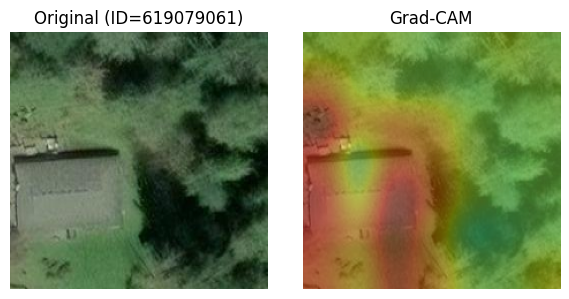

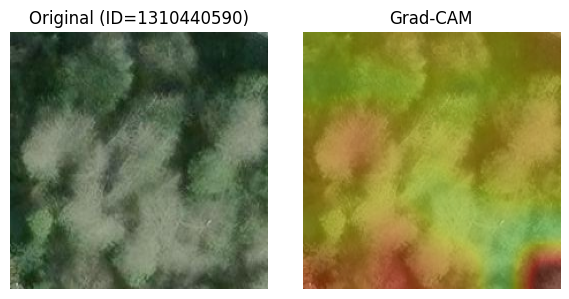

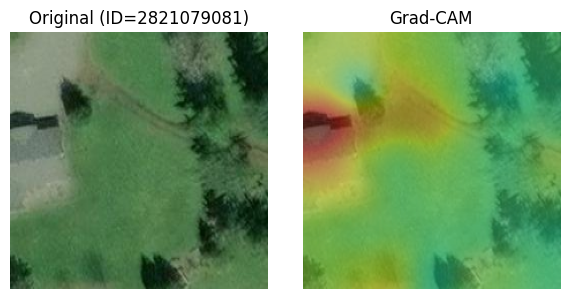

In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for pid in sample_ids:
    if pid not in id_to_filename:
        print(f"Skipping {pid}: image not found")
        continue

    img_path = os.path.join(IMAGE_DIR, id_to_filename[pid])

    img = Image.open(img_path).convert("RGB").resize((224,224))
    img_array = np.expand_dims(np.array(img), axis=0)
    img_array = preprocess_input(img_array)

    heatmap = compute_gradcam(
        img_array,
        grad_model,
        last_conv_layer_name="top_conv"
    )

    overlay = overlay_gradcam(np.array(img), heatmap)

    plt.figure(figsize=(6,3))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original (ID={pid})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img)
axes[0].set_title(f"Original (ID={pid})")
axes[0].axis("off")

axes[1].imshow(overlay)
axes[1].set_title("Grad-CAM")
axes[1].axis("off")

plt.tight_layout()

save_path = os.path.join(
    GRADCAM_DIR,
    f"gradcam_green_{pid}.png"
)
plt.savefig(save_path, dpi=200, bbox_inches="tight")
plt.close()

print(f"Saved Grad-CAM to: {save_path}")


Saved Grad-CAM to: /content/drive/MyDrive/property_valuation_project/outputs/gradcam_v2/gradcam_green_2821079081.png


In [20]:
sample_ids = (
    image_features_df
    .sort_values("edge_density", ascending=False)
    .head(3)["id"]
    .astype(int)
    .values
)

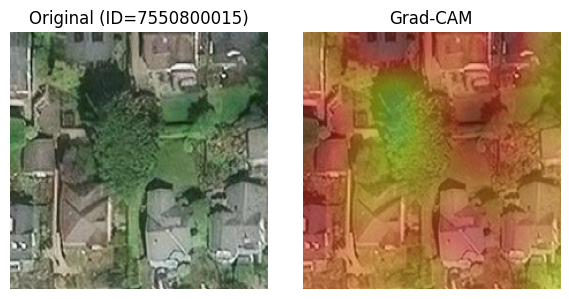

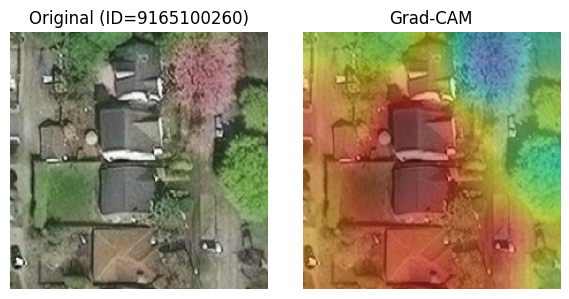

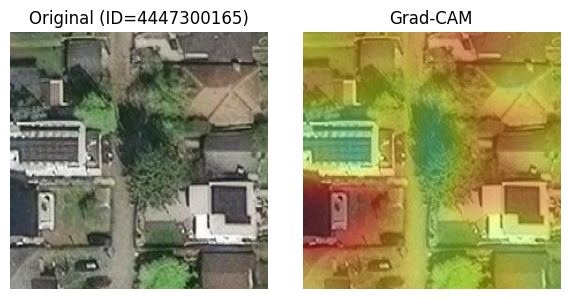

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for pid in sample_ids:
    if pid not in id_to_filename:
        print(f"Skipping {pid}: image not found")
        continue

    img_path = os.path.join(IMAGE_DIR, id_to_filename[pid])

    img = Image.open(img_path).convert("RGB").resize((224,224))
    img_array = np.expand_dims(np.array(img), axis=0)
    img_array = preprocess_input(img_array)

    heatmap = compute_gradcam(
        img_array,
        grad_model,
        last_conv_layer_name="top_conv"
    )

    overlay = overlay_gradcam(np.array(img), heatmap)

    plt.figure(figsize=(6,3))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original (ID={pid})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img)
axes[0].set_title(f"Original (ID={pid})")
axes[0].axis("off")

axes[1].imshow(overlay)
axes[1].set_title("Grad-CAM")
axes[1].axis("off")

plt.tight_layout()

save_path = os.path.join(
    GRADCAM_DIR,
    f"gradcam_edge_density_{pid}.png"
)
plt.savefig(save_path, dpi=200, bbox_inches="tight")
plt.close()

print(f"Saved Grad-CAM to: {save_path}")


Saved Grad-CAM to: /content/drive/MyDrive/property_valuation_project/outputs/gradcam_v2/gradcam_edge_density_4447300165.png


In [23]:
sample_ids = (
    image_features_df
    .sort_values("water_ratio", ascending=False)
    .head(3)["id"]
    .astype(int)
    .values
)

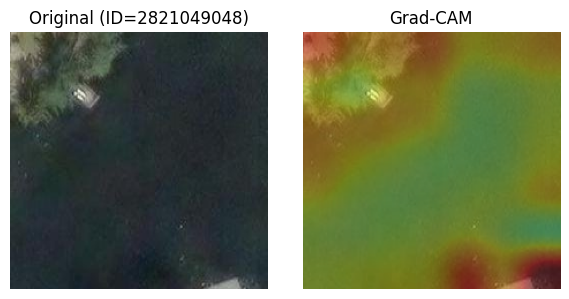

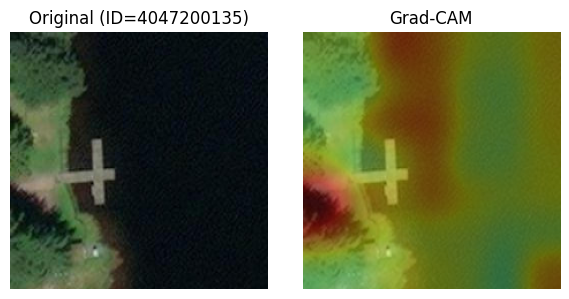

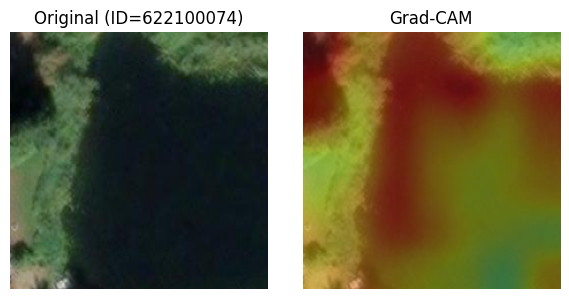

In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for pid in sample_ids:
    if pid not in id_to_filename:
        print(f"Skipping {pid}: image not found")
        continue

    img_path = os.path.join(IMAGE_DIR, id_to_filename[pid])

    img = Image.open(img_path).convert("RGB").resize((224,224))
    img_array = np.expand_dims(np.array(img), axis=0)
    img_array = preprocess_input(img_array)

    heatmap = compute_gradcam(
        img_array,
        grad_model,
        last_conv_layer_name="top_conv"
    )

    overlay = overlay_gradcam(np.array(img), heatmap)

    plt.figure(figsize=(6,3))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original (ID={pid})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img)
axes[0].set_title(f"Original (ID={pid})")
axes[0].axis("off")

axes[1].imshow(overlay)
axes[1].set_title("Grad-CAM")
axes[1].axis("off")

plt.tight_layout()

save_path = os.path.join(
    GRADCAM_DIR,
    f"gradcam_water_{pid}.png"
)
plt.savefig(save_path, dpi=200, bbox_inches="tight")
plt.close()

print(f"Saved Grad-CAM to: {save_path}")


Saved Grad-CAM to: /content/drive/MyDrive/property_valuation_project/outputs/gradcam_v2/gradcam_water_622100074.png


In [26]:
sample_ids = (
    image_features_df
    .sort_values("built_up", ascending=False)
    .head(3)["id"]
    .astype(int)
    .values
)

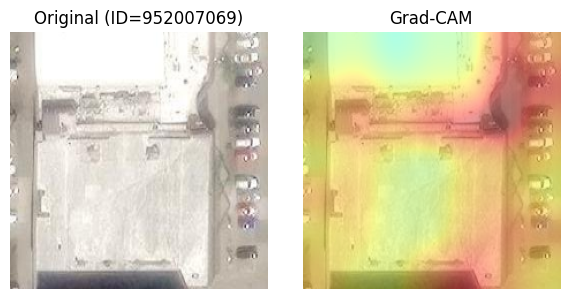

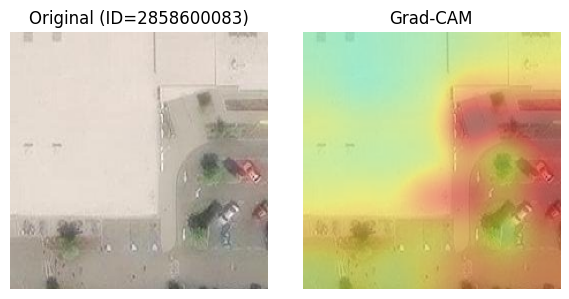

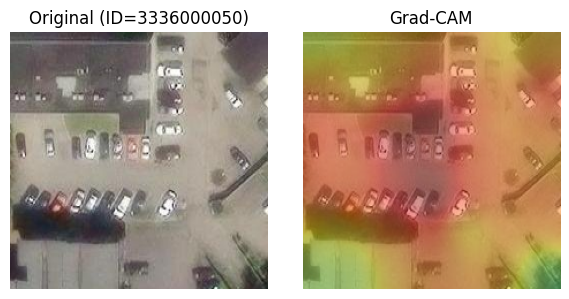

In [27]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for pid in sample_ids:
    if pid not in id_to_filename:
        print(f"Skipping {pid}: image not found")
        continue

    img_path = os.path.join(IMAGE_DIR, id_to_filename[pid])

    img = Image.open(img_path).convert("RGB").resize((224,224))
    img_array = np.expand_dims(np.array(img), axis=0)
    img_array = preprocess_input(img_array)

    heatmap = compute_gradcam(
        img_array,
        grad_model,
        last_conv_layer_name="top_conv"
    )

    overlay = overlay_gradcam(np.array(img), heatmap)

    plt.figure(figsize=(6,3))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original (ID={pid})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [28]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(img)
axes[0].set_title(f"Original (ID={pid})")
axes[0].axis("off")

axes[1].imshow(overlay)
axes[1].set_title("Grad-CAM")
axes[1].axis("off")

plt.tight_layout()

save_path = os.path.join(
    GRADCAM_DIR,
    f"gradcam_built_up_{pid}.png"
)
plt.savefig(save_path, dpi=200, bbox_inches="tight")
plt.close()

print(f"Saved Grad-CAM to: {save_path}")


Saved Grad-CAM to: /content/drive/MyDrive/property_valuation_project/outputs/gradcam_v2/gradcam_built_up_3336000050.png


### Grad-CAM Explainability Analysis

To ensure transparency and interpretability of the visual component of the multimodal valuation pipeline, Grad-CAM was applied to the convolutional backbone (EfficientNet-B0) used during feature extraction. The same pretrained network architecture and weights were retained to maintain consistency between feature generation and explainability.

Grad-CAM visualizations reveal that the CNN consistently focuses on semantically meaningful regions of the satellite imagery. In vegetation-rich neighborhoods, activation maps highlight dense tree canopies and green belts surrounding properties. In water-adjacent regions, the model attends strongly to shoreline boundaries, docks, and water–land interfaces. Urban and built-up areas exhibit activation over rooftops, parking lots, and road networks, reflecting sensitivity to structural density and connectivity.

These observations align closely with the engineered semantic features (green ratio, water ratio, edge density, and built-up density) and explain why satellite imagery improves prediction accuracy primarily in environmentally distinctive neighborhoods. The Grad-CAM results confirm that the CNN extracts spatial context beyond simple color cues and that the visual gating mechanism successfully emphasizes informative imagery while suppressing noise.

Overall, Grad-CAM provides qualitative evidence that satellite imagery contributes complementary neighborhood-level signals that are not captured by tabular attributes alone.